In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import glob
import os
import pickle
import random
import sys

import ivac
import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj as md
import numpy as np
import prettypyplot as pplt
import pyemma
import scipy
import seaborn as sns
from matplotlib import ticker
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors

import extq

In [3]:
! source /project/dinner/scguo/upside2/sourceme.sh

In [4]:
# upside_path = os.environ["UPSIDE_HOME"]
upside_path = "/project/dinner/scguo/upside2/"
upside_utils_dir = os.path.expanduser(upside_path + "/py")
sys.path.insert(0, upside_utils_dir)

In [5]:
plt.style.use("custom")  # custom style sheet
plt.style.use("vibrant")  # muted color theme from SciencePlots
pplt.load_cmaps()

In [6]:
plt.rcParams['text.latex.preamble'] = r'\usepackage{siunitx}\sisetup{detect-all}\usepackage{helvet}\usepackage{sansmath}\sansmath'
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'cm'

# Load data

In [7]:
home_dir = "/project/dinner/scguo/kaiB"
base_dir = "/project/dinner/scguo/kaiB/dga/87"

In [8]:
def load_cvs(base_dir, n_s, n_i):
    raw_feats, fs_qtots, f_rmsds, p_rmsds, r_rmsds = [], [], [], [], []
    for i in range(n_s):
        for j in range(n_i):
            for iso in ("cis", "trans"):
                idx = f"{i:02}_{j:02}_{iso}"
                head = f"{idx}_dga"
                if not os.path.exists(f"{base_dir}/{idx}/outputs/{head}_raw_feats.pkl"):
                    continue
                raw_feats.extend(
                    np.load(f"{base_dir}/{idx}/outputs/{head}_raw_feats.pkl", allow_pickle=True)
                )
                fs_qtots.extend(np.load(f"{base_dir}/{idx}/outputs/{head}_fs_qtots.pkl", allow_pickle=True))
                f_rmsds.extend(np.load(f"{base_dir}/{idx}/outputs/{head}_f_rmsds.pkl", allow_pickle=True))
                p_rmsds.extend(np.load(f"{base_dir}/{idx}/outputs/{head}_p_rmsds.pkl", allow_pickle=True))
                r_rmsds.extend(np.load(f"{base_dir}/{idx}/outputs/{head}_r_rmsds.pkl", allow_pickle=True))
    return raw_feats, fs_qtots, f_rmsds, p_rmsds, r_rmsds

In [9]:
raw_feats, fs_qtots, f_rmsds, p_rmsds, r_rmsds = load_cvs(base_dir, 7, 32)

In [10]:
print(len(raw_feats), raw_feats[0].shape)

896 (39997, 325)


In [11]:
# Adam's CVs
c_gsa1 = np.concatenate([traj[1, :] for traj in fs_qtots])
c_gsa2 = np.concatenate([traj[3, :] for traj in fs_qtots])
c_gsb2 = np.concatenate([traj[5, :] for traj in fs_qtots])

c_fsb1 = np.concatenate([traj[0, :] for traj in fs_qtots])
c_fsb2 = np.concatenate([traj[2, :] for traj in fs_qtots])
c_fsa2 = np.concatenate([traj[4, :] for traj in fs_qtots])

c_green_arr = c_gsa2 - c_fsb2
c_blue_arr = c_gsb2 - c_fsa2
c_orange_arr = c_gsa1 - c_fsb1

c_green = [traj[3, :] - traj[2, :] for traj in fs_qtots]
c_blue = [traj[5, :] - traj[4, :] for traj in fs_qtots]
c_orange = [traj[1, :] - traj[0, :] for traj in fs_qtots]

In [12]:
p_rmsd_arr = np.asarray(p_rmsds).ravel()
f_rmsd_arr = np.asarray(f_rmsds).ravel()
in_fs = np.logical_and(
    c_green_arr < -0.78,
    np.logical_and(c_blue_arr < -0.83, np.logical_and(c_orange_arr < -0.75, f_rmsd_arr < 0.35)),
)

in_gs = np.logical_and(
    c_green_arr > 0.67,
    np.logical_and(c_blue_arr > 0.88, np.logical_and(c_orange_arr > 0.75, p_rmsd_arr < 0.45)),
)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: cm
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: cm


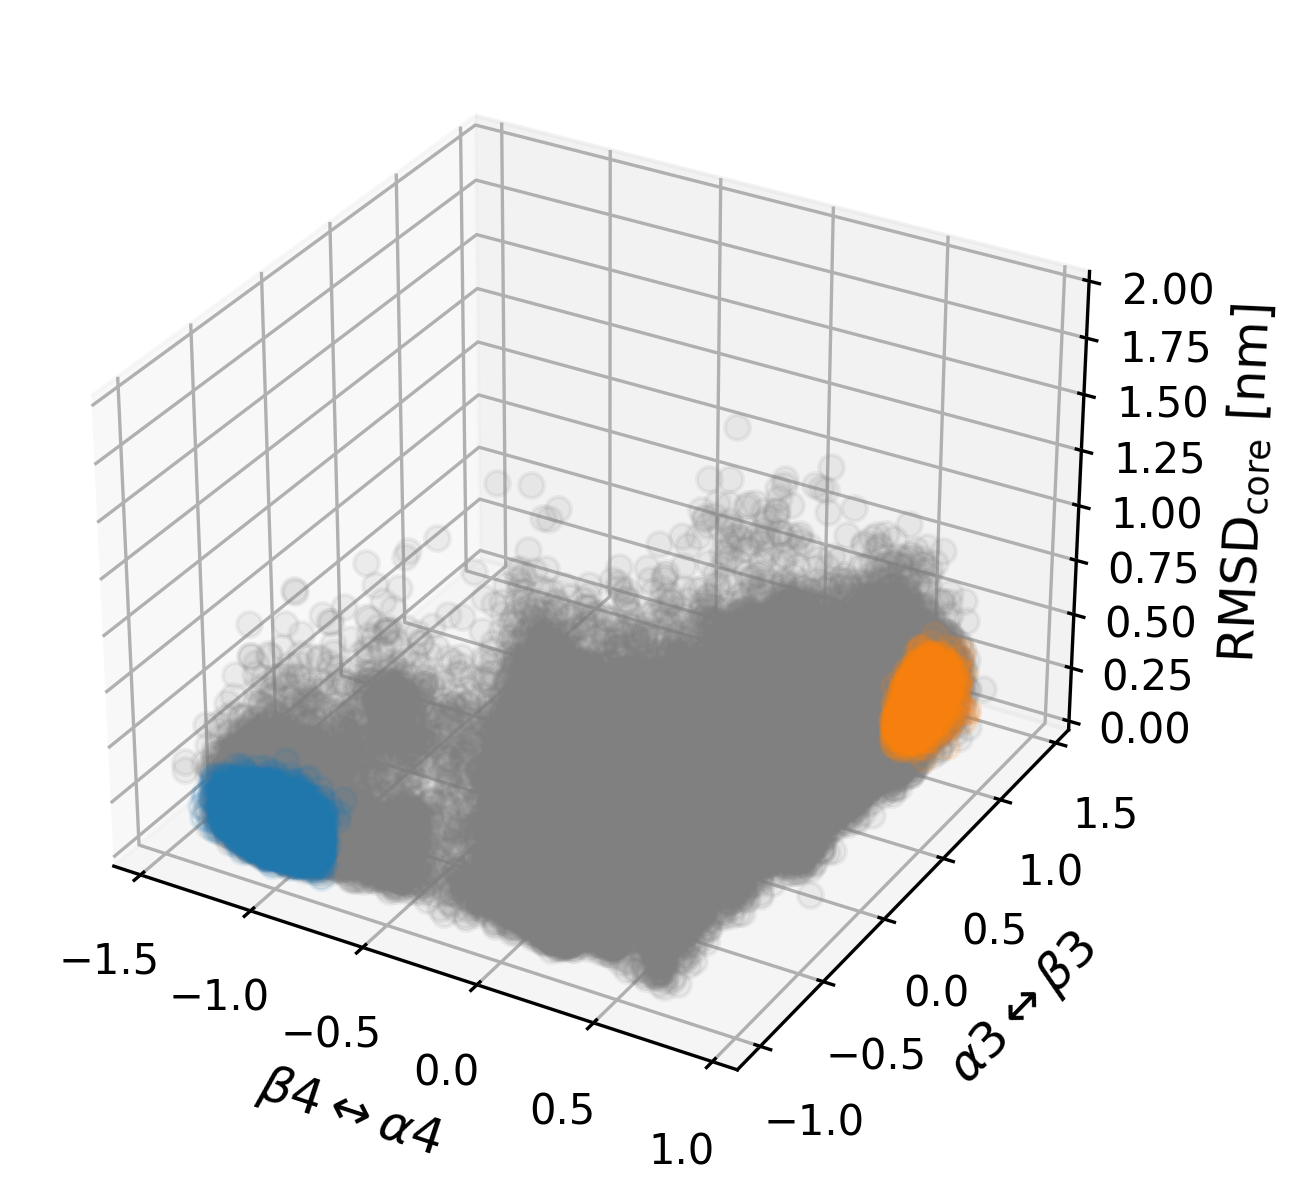

In [14]:
r_rmsd_arr = np.asarray(r_rmsds).ravel()
fig = plt.figure(figsize=(4, 4), dpi=300)
ax = fig.add_subplot(projection="3d")
ax.plot(c_green_arr[::500], c_blue_arr[::500], r_rmsd_arr[::500], "o", color="gray", alpha=0.1)
ax.plot(
    c_green_arr[in_fs][::500],
    c_blue_arr[in_fs][::500],
    r_rmsd_arr[in_fs][::500],
    "o",
    color="C0",
    alpha=0.1,
)
ax.plot(
    c_green_arr[in_gs][::500],
    c_blue_arr[in_gs][::500],
    r_rmsd_arr[in_gs][::500],
    "o",
    color="C1",
    alpha=0.1,
)
ax.set_zlim([0, 2])
ax.set_xlabel(r"$\beta4\leftrightarrow \alpha4$", fontsize=12)
ax.set_ylabel(r"$\alpha3\leftrightarrow\beta3$", fontsize=12)
ax.set_zlabel(r"RMSD$_{\mathrm{core}}$ [nm]", fontsize=12)
fig.tight_layout()

# IVAC

In [13]:
# np.save(f"{base_dir}/dga_data/ivac_10d_10-1000.npy", ivac_trajs)
ivac_trajs = np.load(f"{base_dir}/dga_data/ivac_10d_10-1000.npy")

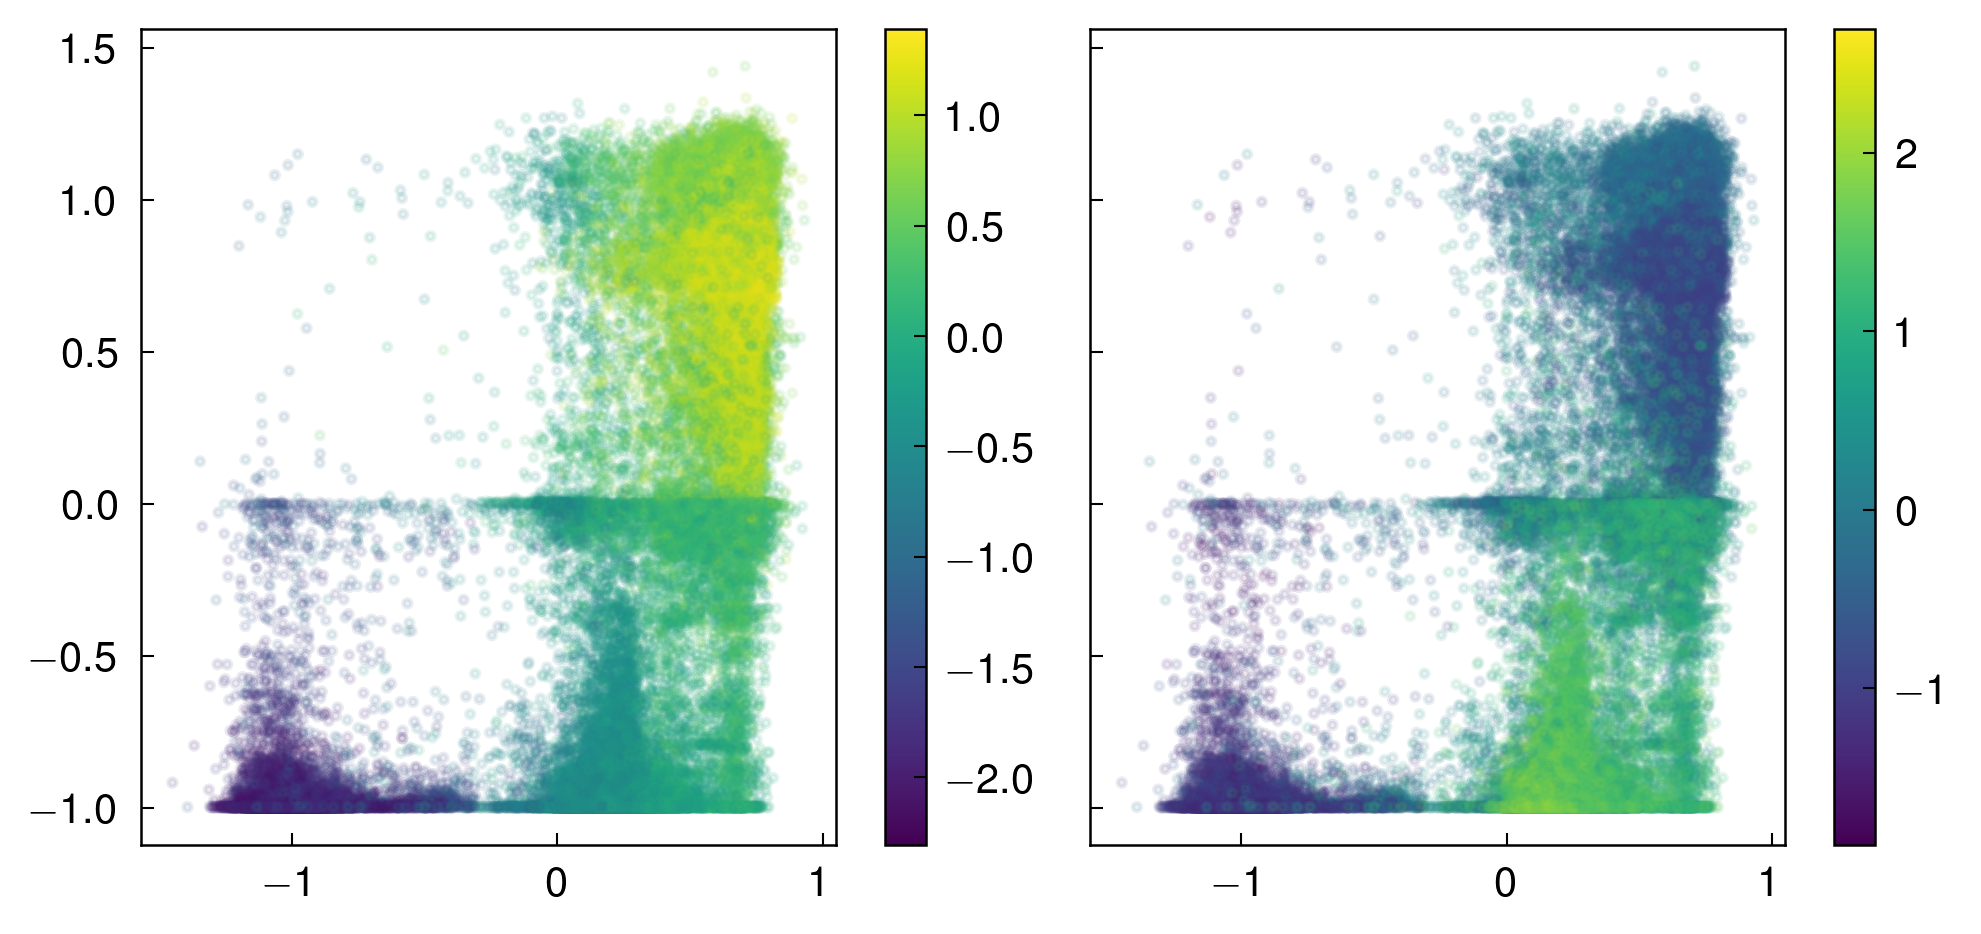

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(6.5, 3), dpi=300, sharex=True, sharey=True, constrained_layout=True)
for i, ax in enumerate(axes):
    sc = ax.scatter(c_green_arr[::500], c_blue_arr[::500], c=np.concatenate(ivac_trajs)[::500, i + 1], alpha=0.1, marker="o")
    cb = plt.colorbar(sc, ax=ax)
    cb.solids.set(alpha=1.)

# $k$-means

In [15]:
dtraj = np.load(f"{base_dir}/dga_data/dtraj_300.npy")

# Utility functions

In [17]:
def split_indices(arrays):
    """Gets the indices for np.split from a
    list of arrays.

    Parameters
    ----------
    arrays : ndarray or list/tuple of ndarray
        Arrays from which to get indices

    Returns
    -------
    traj_inds : list of int
        Frame separators to use in np.split
    """
    traj_lens = [len(traj) for traj in arrays]
    traj_inds = []
    subtot = 0
    for length in traj_lens[:-1]:
        subtot += length
        traj_inds.append(subtot)
    return traj_inds

In [18]:
traj_inds = split_indices(raw_feats)

# Weights, PMF, eq averages, committors

In [13]:
# saved every 50 time steps
lags = np.array([100, 200, 500, 1000, 2000, 5000], dtype=int)
lagtimes = lags * 50

In [19]:
weights = np.load(f"{base_dir}/dga_data/weights.npy", allow_pickle=True)

In [20]:
in_domain = ~(in_fs | in_gs)
in_d = np.split(in_domain, traj_inds)

In [21]:
qp_fs2gs = np.load(f"{base_dir}/dga_data/qp_fs2gs.npy", allow_pickle=True)
qp_gs2fs = np.load(f"{base_dir}/dga_data/qp_gs2fs.npy", allow_pickle=True)
# qm_fs2gs = np.load(f"{base_dir}/dga_data/qm_fs2gs.npy", allow_pickle=True)
# qm_gs2fs = np.load(f"{base_dir}/dga_data/qm_gs2fs.npy", allow_pickle=True)

In [22]:
def adjust_forward_committor(forward_q, in_domain, lag):
    result_qp = []
    for qp, d in zip(forward_q, in_domain):
        n = len(d)
        assert len(qp) == n
        tp = extq.stop.forward_stop(d)
        iy = np.minimum(np.arange(lag, n), tp[:-lag])
        result_qp.append(qp[iy])
    return result_qp

## PLots

/project/dinner/scguo/extq/src/extq/projection.py:140: RuntimeWarning: invalid value encountered in divide
  return numer / denom


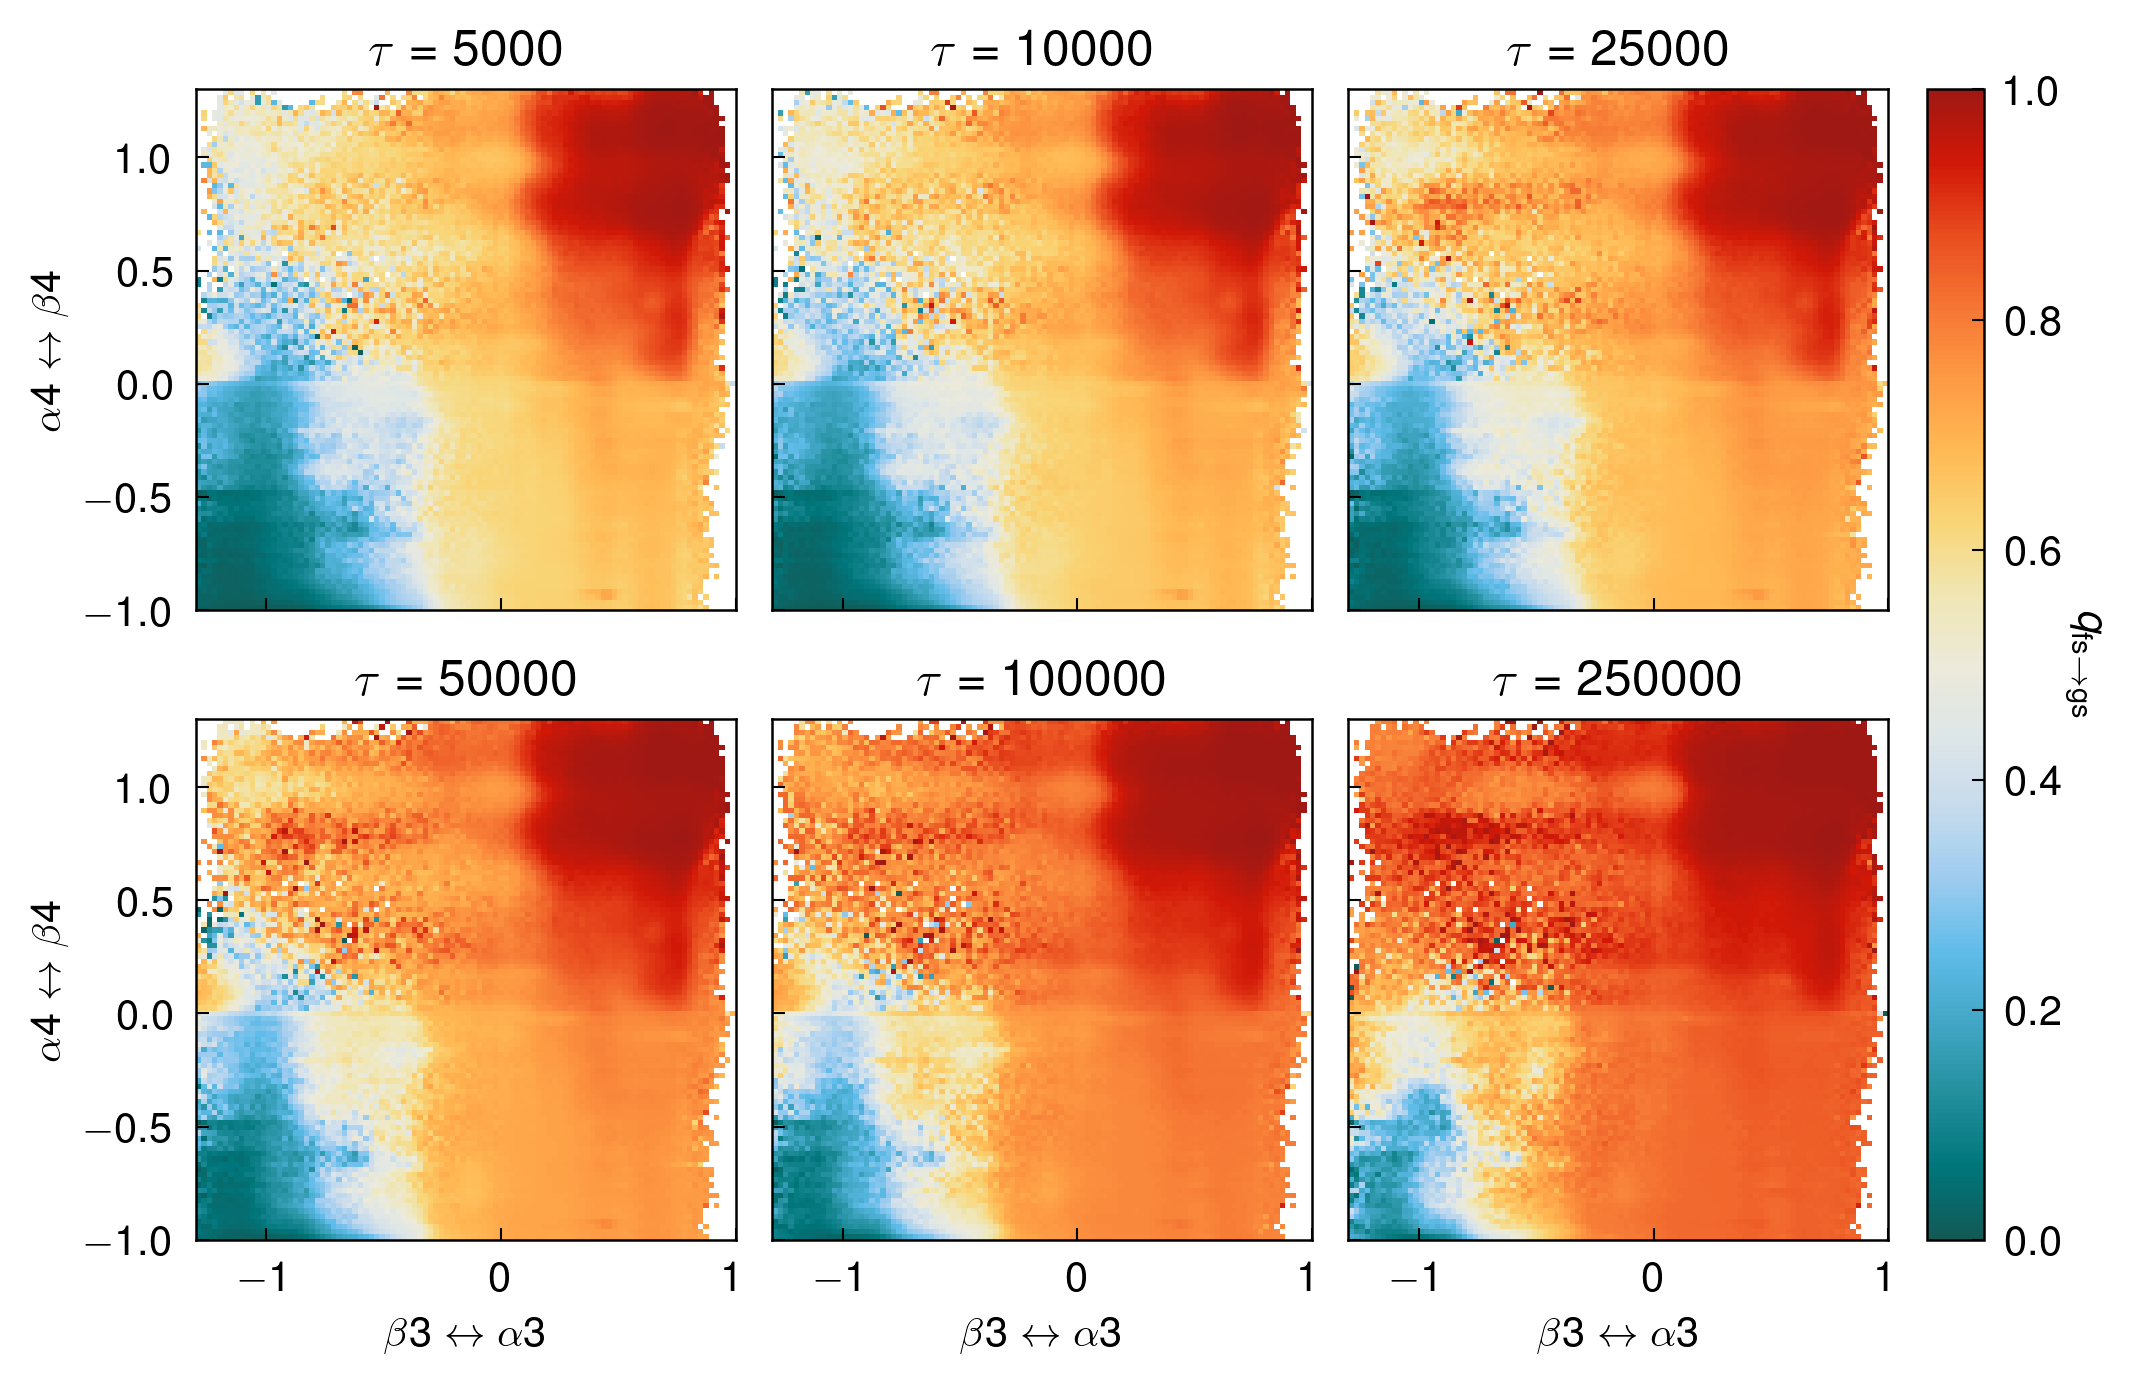

In [23]:
# plot against "GT" and "BT"
fig, axes = plt.subplots(
    nrows=2, ncols=3, figsize=(7, 4.5), dpi=300, sharex=True, sharey=True, constrained_layout=True
)

xe = np.linspace(-1.3, 1, 101)
ye = np.linspace(-1, 1.3, 101)
xc = (xe[1:] + xe[:-1]) / 2
yc = (ye[1:] + ye[:-1]) / 2
clines = np.linspace(0, 1, 11)

for ax, lag, lagtime, w, q in zip(axes.flat, lags, lagtimes, weights, qp_fs2gs):
    w_delay = [t[:-lag] for t in w]
    cv1_delay = [t[:-lag] for t in c_green]
    cv2_delay = [t[:-lag] for t in c_blue]
    qp_delay = adjust_forward_committor(q, in_d, lag)
    hist = extq.projection.average2d(cv1_delay, cv2_delay, qp_delay, w_delay, xe, ye)
    pc = ax.pcolormesh(xc, yc, hist.T, cmap="nightfall", vmin=0, vmax=1)
    # ax.contour(xc, yc, hist.T, colors="black", levels=clines)
    ax.set_ylabel(r"$\alpha4\leftrightarrow \beta4$")
    ax.set_xlabel(r"$\beta3\leftrightarrow\alpha3$")
    ax.set_title(f"$\\tau$ = {lagtime}")
    ax.label_outer()
cb = plt.colorbar(pc, ax=axes[:, -1])
cb.set_label(r"$q_{\mathrm{fs}\rightarrow\mathrm{gs}}$", rotation=-90, labelpad=10)

/project/dinner/scguo/extq/src/extq/projection.py:140: RuntimeWarning: invalid value encountered in divide
  return numer / denom


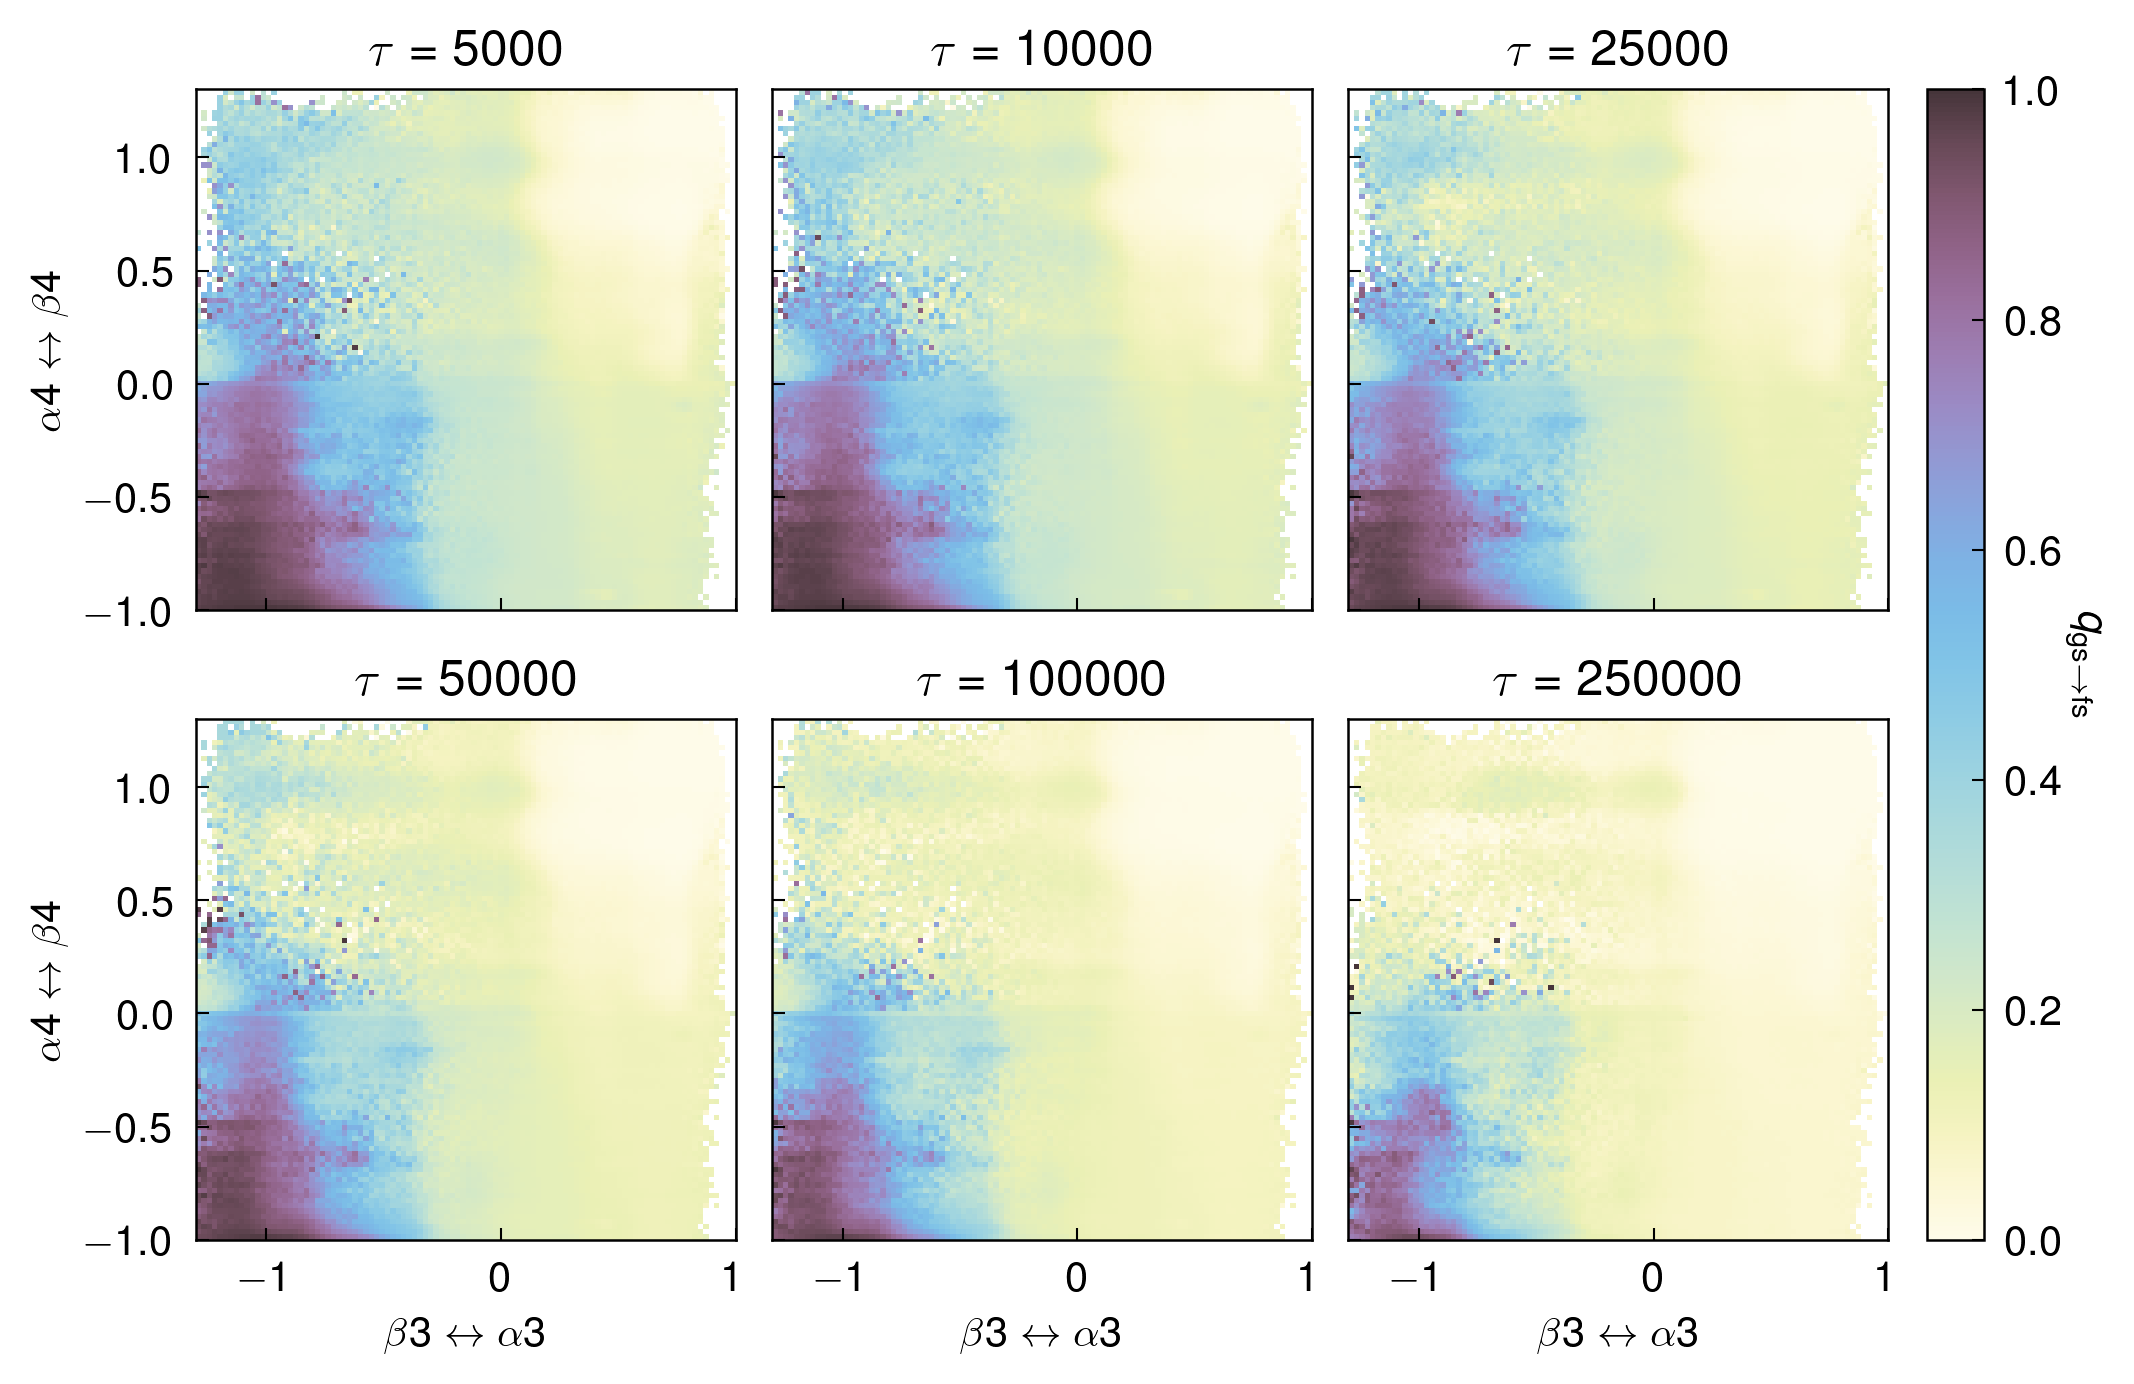

In [24]:
# plot against "GT" and "BT"
fig, axes = plt.subplots(
    nrows=2, ncols=3, figsize=(7, 4.5), dpi=300, sharex=True, sharey=True, constrained_layout=True
)

xe = np.linspace(-1.3, 1, 101)
ye = np.linspace(-1, 1.3, 101)
xc = (xe[1:] + xe[:-1]) / 2
yc = (ye[1:] + ye[:-1]) / 2
clines = np.linspace(0, 1, 11)

for ax, lag, lagtime, w, q in zip(axes.flat, lags, lagtimes, weights, qp_gs2fs):
    w_delay = [t[:-lag] for t in w]
    cv1_delay = [t[:-lag] for t in c_green]
    cv2_delay = [t[:-lag] for t in c_blue]
    qp_delay = adjust_forward_committor(q, in_d, lag)
    hist = extq.projection.average2d(cv1_delay, cv2_delay, qp_delay, w_delay, xe, ye)
    pc = ax.pcolormesh(xc, yc, hist.T, cmap="iridescent", vmin=0, vmax=1)
    # ax.contour(xc, yc, hist.T, colors="black", levels=clines)
    ax.set_ylabel(r"$\alpha4\leftrightarrow \beta4$")
    ax.set_xlabel(r"$\beta3\leftrightarrow\alpha3$")
    ax.set_title(f"$\\tau$ = {lagtime}")
    ax.label_outer()
cb = plt.colorbar(pc, ax=axes[:, -1])
cb.set_label(r"$q_{\mathrm{gs}\rightarrow\mathrm{fs}}$", rotation=-90, labelpad=10)

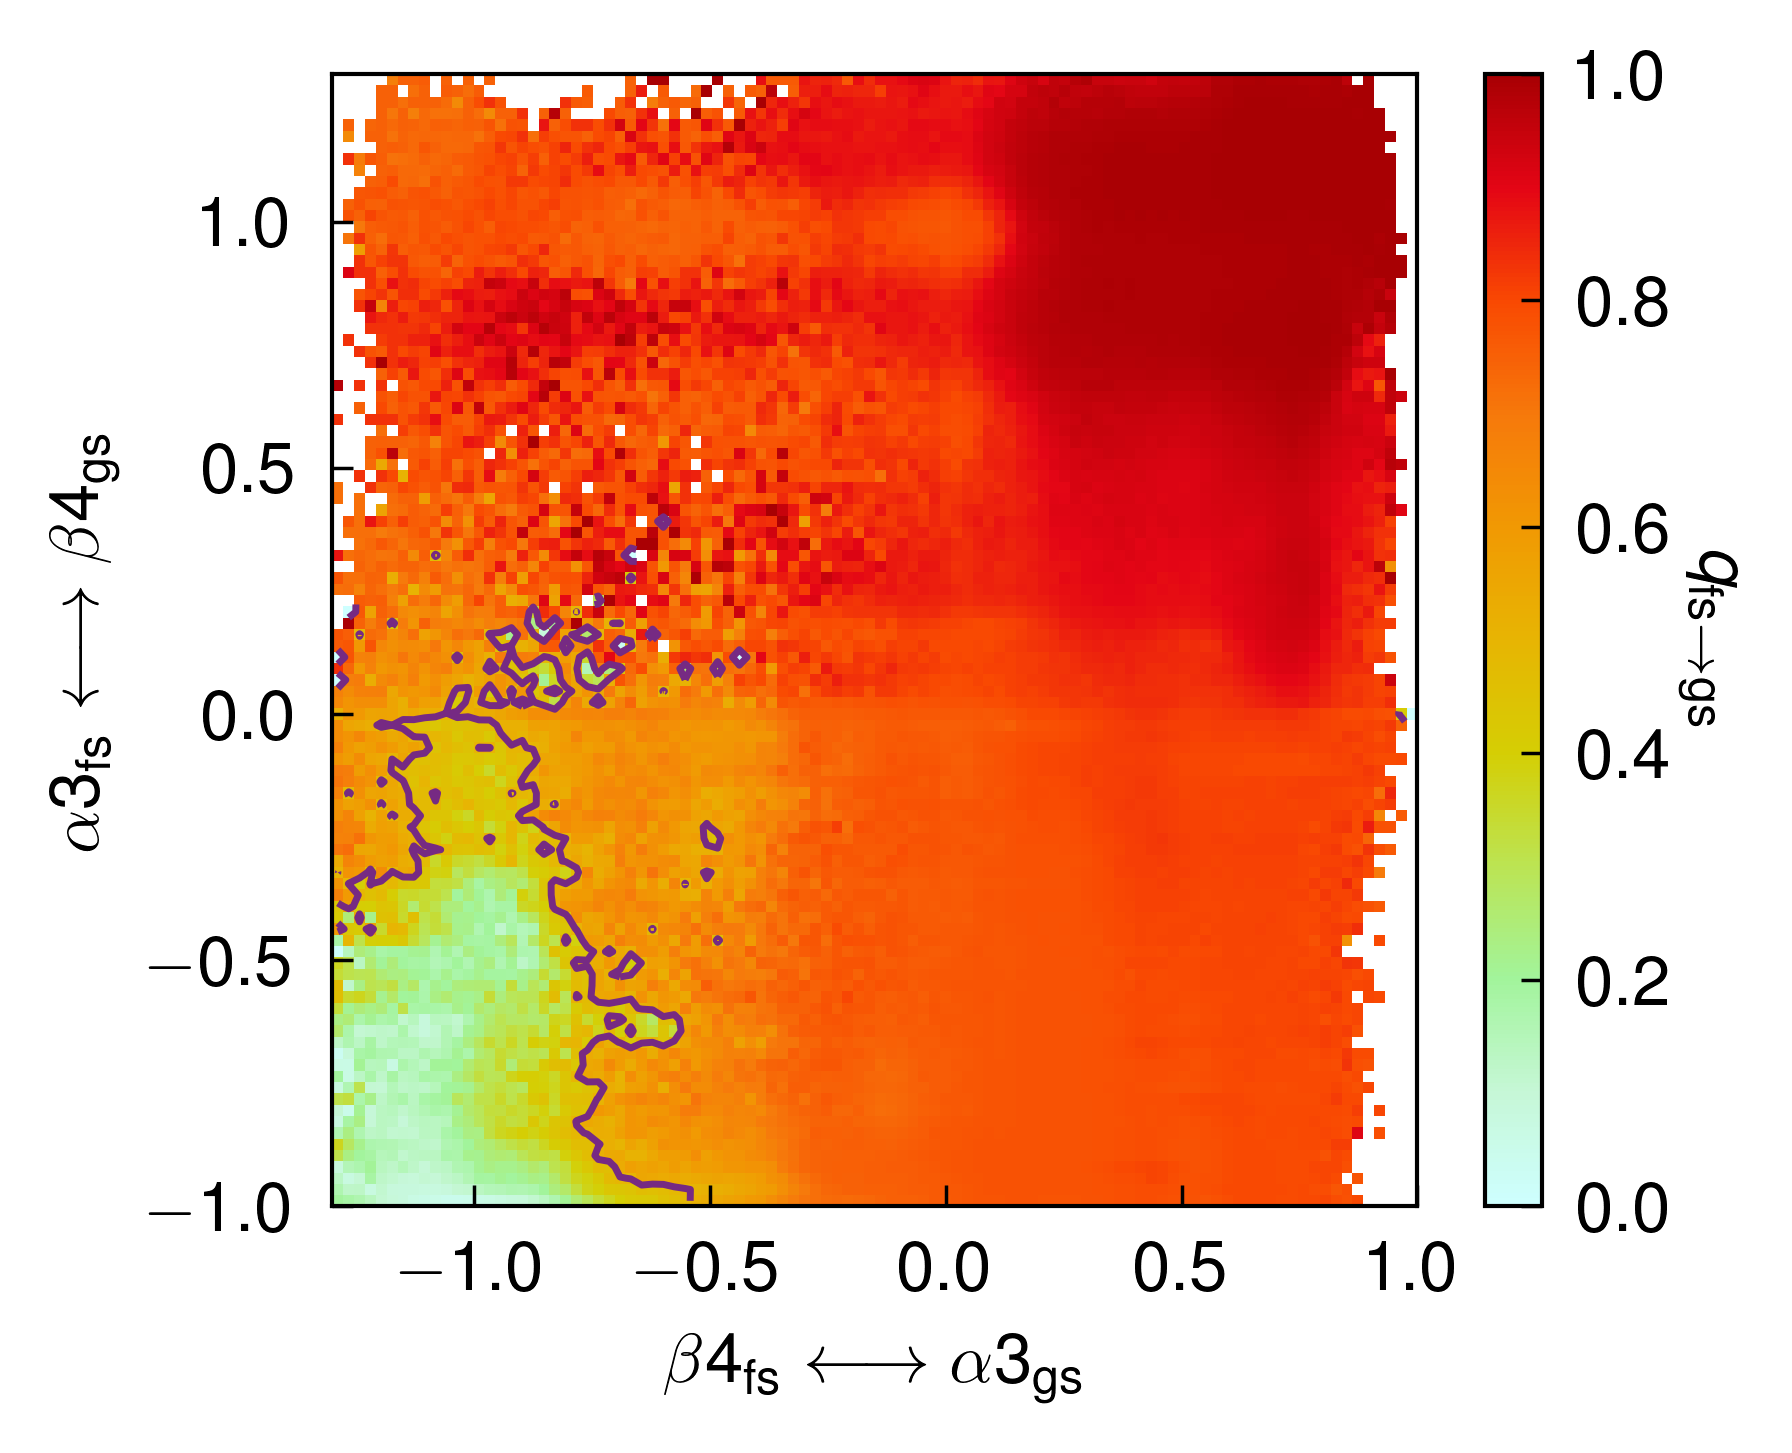

In [26]:
# plot against "GT" and "BT"
fig, ax = plt.subplots(figsize=(3.5, 3), dpi=500)

xe = np.linspace(-1.3, 1, 101)
ye = np.linspace(-1, 1.3, 101)
xc = (xe[1:] + xe[:-1]) / 2
yc = (ye[1:] + ye[:-1]) / 2
# clines = np.linspace(0, 1, 11)
# colors = ["grey" if i != 5 else "purple" for i in range(10)]

w_delay = [t[:-lag] for t in weights[-1]]
cv1_delay = [t[:-lag] for t in c_green]
cv2_delay = [t[:-lag] for t in c_blue]
qp_delay = adjust_forward_committor(qp_fs2gs[4], in_d, lag)
hist = extq.projection.average2d(cv1_delay, cv2_delay, qp_delay, w_delay, xe, ye)
pc = ax.pcolormesh(xc, yc, hist.T, cmap="incandescent", vmin=0, vmax=1, rasterized=True)
ax.contour(xc, yc, hist.T, colors="#762A83", levels=[0.5], linewidths=1)
ax.set_ylabel(r"$\alpha3_{\mathrm{fs}}\longleftrightarrow \beta4_{\mathrm{gs}}$")
ax.set_xlabel(r"$\beta4_{\mathrm{fs}}\longleftrightarrow\alpha3_{\mathrm{gs}}$")
ax.label_outer()
cb = plt.colorbar(pc, ax=ax)
cb.set_label(r"$q_{\mathrm{fs}\rightarrow\mathrm{gs}}$", rotation=-90, labelpad=10)
# plt.savefig("../../dga/figures/t87_qpfs2gs.pdf", bbox_inches='tight')

/scratch/local/jobs/7298669/ipykernel_4046844/1553712651.py:17: UserWarning: The following kwargs were not used by contour: 'linewidth'
  ax.contour(xc, yc, hist.T, colors="black", levels=[0.5], linewidth=1)


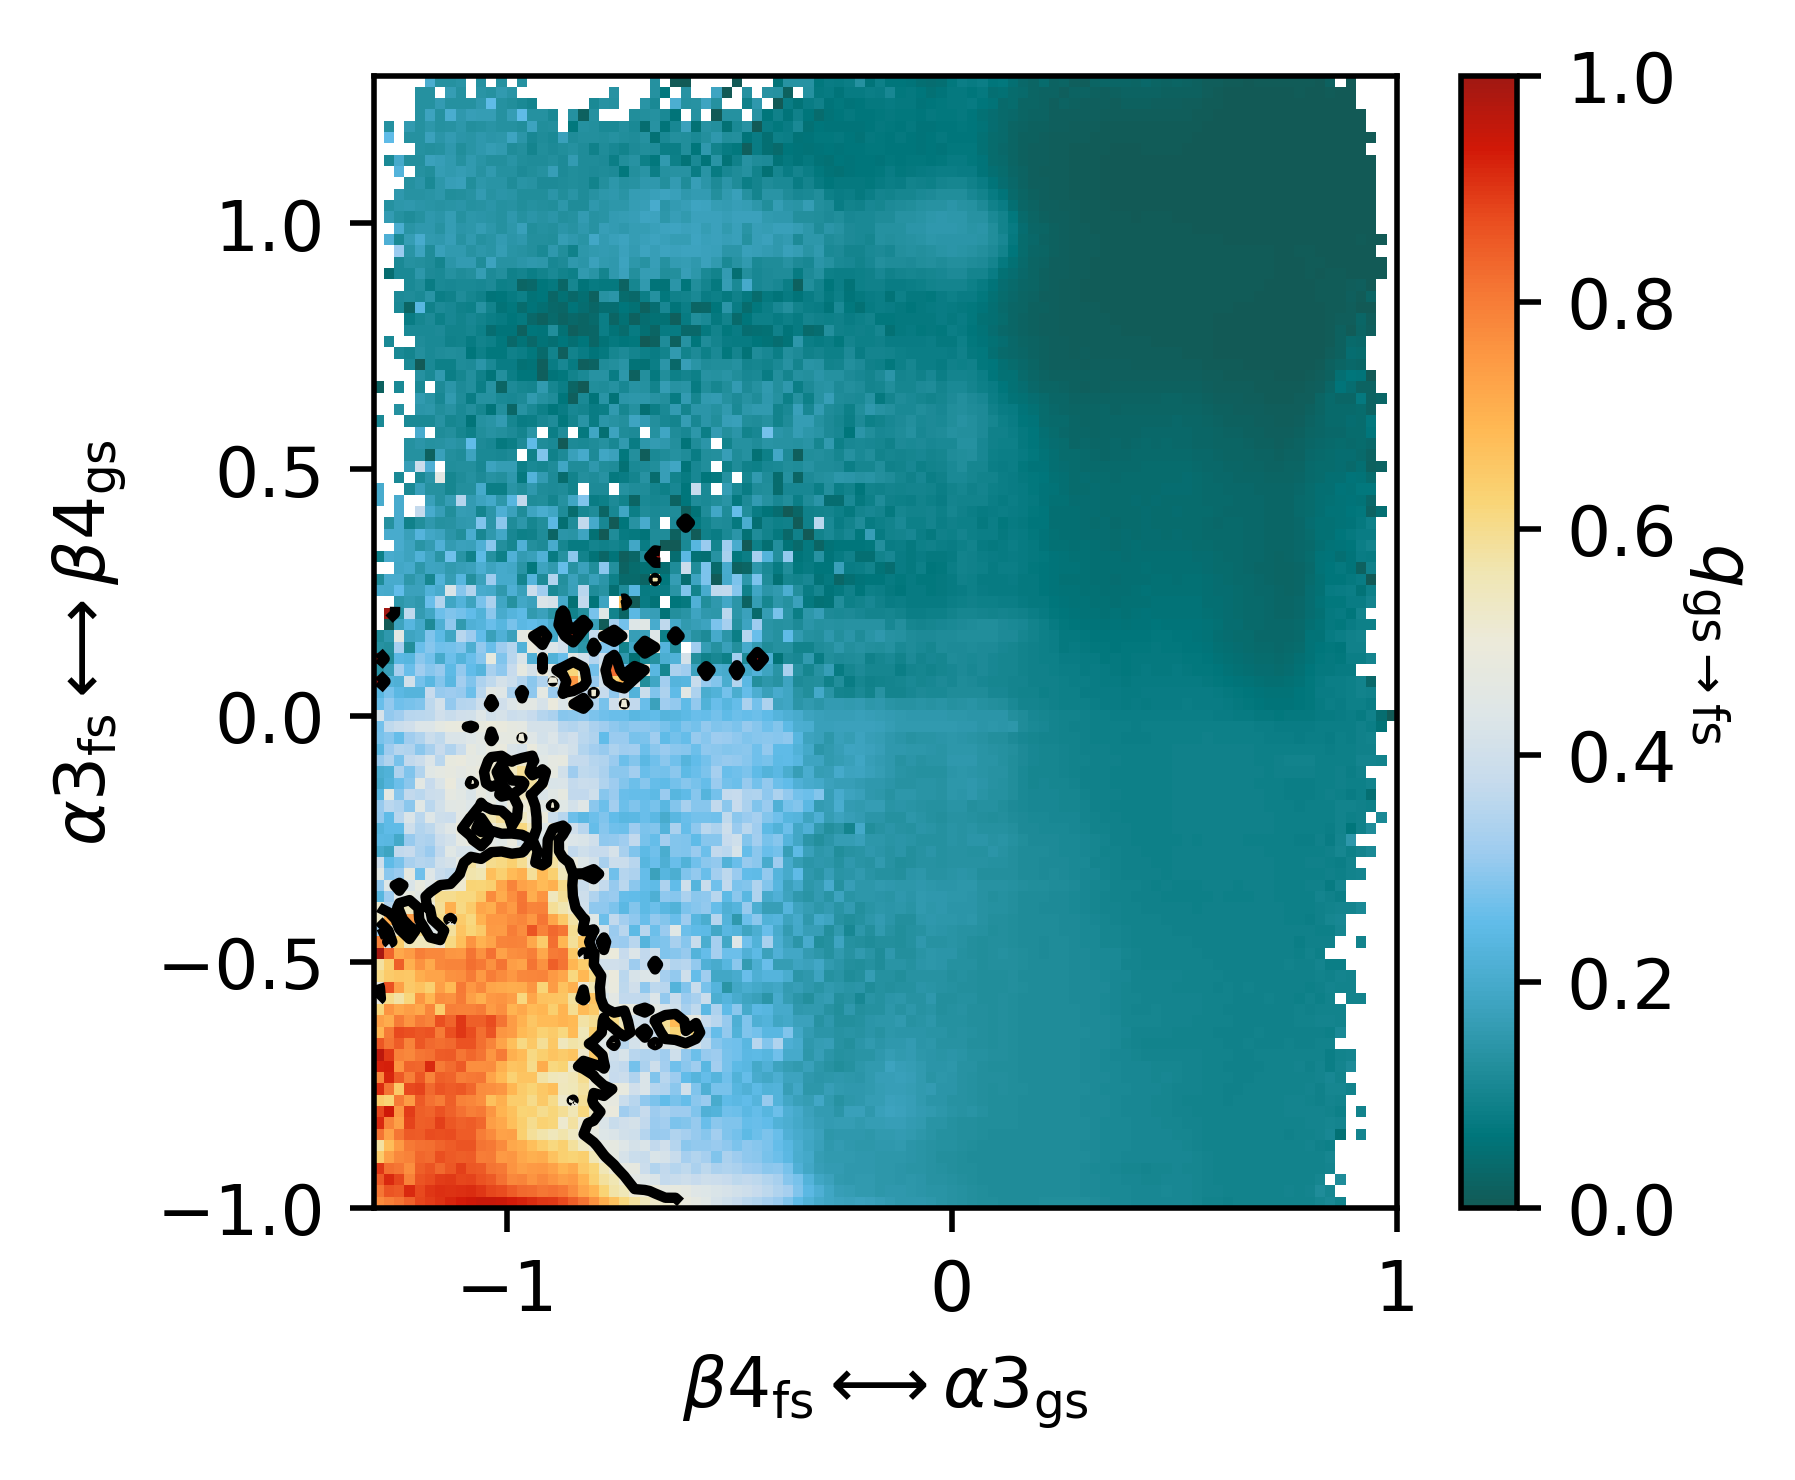

In [36]:
# plot against "GT" and "BT"
fig, ax = plt.subplots(figsize=(3.3, 3), dpi=500)

xe = np.linspace(-1.3, 1, 101)
ye = np.linspace(-1, 1.3, 101)
xc = (xe[1:] + xe[:-1]) / 2
yc = (ye[1:] + ye[:-1]) / 2
# clines = np.linspace(0, 1, 11)
# colors = ["grey" if i != 5 else "purple" for i in range(10)]

w_delay = [t[:-lag] for t in weights[-1]]
cv1_delay = [t[:-lag] for t in c_green]
cv2_delay = [t[:-lag] for t in c_blue]
qp_delay = adjust_forward_committor(qp_gs2fs[4], in_d, lag)
hist = extq.projection.average2d(cv1_delay, cv2_delay, qp_delay, w_delay, xe, ye)
pc = ax.pcolormesh(xc, yc, hist.T, cmap="nightfall", vmin=0, vmax=1, rasterized=True)
ax.contour(xc, yc, hist.T, colors="black", levels=[0.5], linewidth=1)
ax.set_ylabel(r"$\alpha3_{\mathrm{fs}}\longleftrightarrow \beta4_{\mathrm{gs}}$")
ax.set_xlabel(r"$\beta4_{\mathrm{fs}}\longleftrightarrow\alpha3_{\mathrm{gs}}$")
ax.label_outer()
cb = plt.colorbar(pc, ax=ax)
cb.set_label(r"$q_{\mathrm{gs}\rightarrow\mathrm{fs}}$", rotation=-90, labelpad=10)

In [1]:
# plot against "GT" and "BT"
fig, ax = plt.subplots(figsize=(3.5, 3), dpi=500)

xe = np.linspace(-1.3, 1, 101)
ye = np.linspace(-1, 1.3, 101)
xc = (xe[1:] + xe[:-1]) / 2
yc = (ye[1:] + ye[:-1]) / 2
clines = np.arange(0, 13, 2)

w_delay = [t[:-lag] for t in weights[-1]]
cv1_delay = [t[lag:] for t in c_green]
cv2_delay = [t[lag:] for t in c_blue]
hist = extq.projection.density2d(cv1_delay, cv2_delay, w_delay, xe, ye)
offset = np.min(-np.log(hist))
pmf = -np.log(hist) - offset
pc = ax.pcolormesh(xc, yc, pmf.T, cmap="iridescent", vmax=13, rasterized=True)
ax.contour(xc, yc, pmf.T, colors="white", levels=clines, linewidths=0.5)
ax.set_ylabel(r"$\alpha3_{\mathrm{fs}}\longleftrightarrow \beta4_{\mathrm{gs}}$")
ax.set_xlabel(r"$\beta4_{\mathrm{fs}}\longleftrightarrow\alpha3_{\mathrm{gs}}$")
# ax.set_title(f"$\\tau$ = {lagtime}")
ax.label_outer()
cb = plt.colorbar(pc, ax=ax, extend="max")
cb.set_label(r"PMF ($k_{\mathrm{B}}T$)", rotation=-90, labelpad=10)
# plt.savefig("../../dga/figures/t87_pmf.pdf", bbox_inches="tight")

NameError: name 'plt' is not defined

## Extract structures

In [27]:
def find_closest_points(point, data, n=1):
    """Find ID of closest point(s) in data to point
    point must be of the same dimensionality as data, i.e.
    point.shape = d, data.shape = (N, d) where N in the number
    of data points

    Parameters
    ----------
    point : array-like of length d
        point to which to find closest values
    data : array-like of shape (N, d)
        data to search
    n : int, optional
        number of indices to return

    Returns
    -------
    indices : array-like of length n
    """
    assert len(point) == data.shape[1]
    distances = np.sum((data - point) ** 2, axis=1)
    return np.argsort(distances)[:n]

In [37]:
def filenames(base_dir, n_s, n_i):
    files = []
    for i in range(n_s):
        for j in range(n_i):
            for iso in ("cis", "trans"):
                for k in range(2):
                    idx = f"{i:02}_{j:02}_{iso}/dga/{i:02}_{j:02}.{k:02}.up"
                    files.append(idx)
    return files

In [43]:
point = [0.5, -1, 0]
idxs = find_closest_points(point, np.column_stack((np.concatenate(qp_fs2gs[4]), c_green_arr, c_blue_arr)), n=10)
files = filenames(base_dir, 7, 32)
for i in idxs:
    traj, frame = divmod(i, 39997)
    print(traj, files[traj], frame)

398 03_03_trans/dga/03_03.00.up 7981
591 04_19_trans/dga/04_19.01.up 30921
2 00_00_trans/dga/00_00.00.up 1315
10 00_02_trans/dga/00_02.00.up 1197
5 00_01_cis/dga/00_01.01.up 2293
5 00_01_cis/dga/00_01.01.up 2262
5 00_01_cis/dga/00_01.01.up 2150
273 02_04_cis/dga/02_04.01.up 27603
608 04_24_cis/dga/04_24.00.up 39746
591 04_19_trans/dga/04_19.01.up 31485


In [44]:
point = [0.5, -0.75, -0.5]
idxs = find_closest_points(point, np.column_stack((np.concatenate(qp_fs2gs[4]), c_green_arr, c_blue_arr)), n=5)
files = filenames(base_dir, 7, 32)
for i in idxs:
    traj, frame = divmod(i, 39997)
    print(traj, files[traj], frame)

10 00_02_trans/dga/00_02.00.up 317
386 03_00_trans/dga/03_00.00.up 21587
521 04_02_cis/dga/04_02.01.up 1165
558 04_11_trans/dga/04_11.00.up 35690
615 04_25_trans/dga/04_25.01.up 30557


In [45]:
point = [0.5, -0.6, -1]
idxs = find_closest_points(point, np.column_stack((np.concatenate(qp_fs2gs[4]), c_green_arr, c_blue_arr)), n=5)
files = filenames(base_dir, 7, 32)
for i in idxs:
    traj, frame = divmod(i, 39997)
    print(traj, files[traj], frame)

275 02_04_trans/dga/02_04.01.up 159
279 02_05_trans/dga/02_05.01.up 28423
277 02_05_cis/dga/02_05.01.up 2675
34 00_08_trans/dga/00_08.00.up 8785
553 04_10_cis/dga/04_10.01.up 25374


# TPT rate

In [28]:
rate_lags = np.array([10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000], dtype=int)

## fs $\rightarrow$ gs

In [29]:
rates_lags = np.load(f"{base_dir}/dga_data/rates_fs2gs.npy")

/scratch/local/jobs/7233195/ipykernel_3568426/625111103.py:15: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


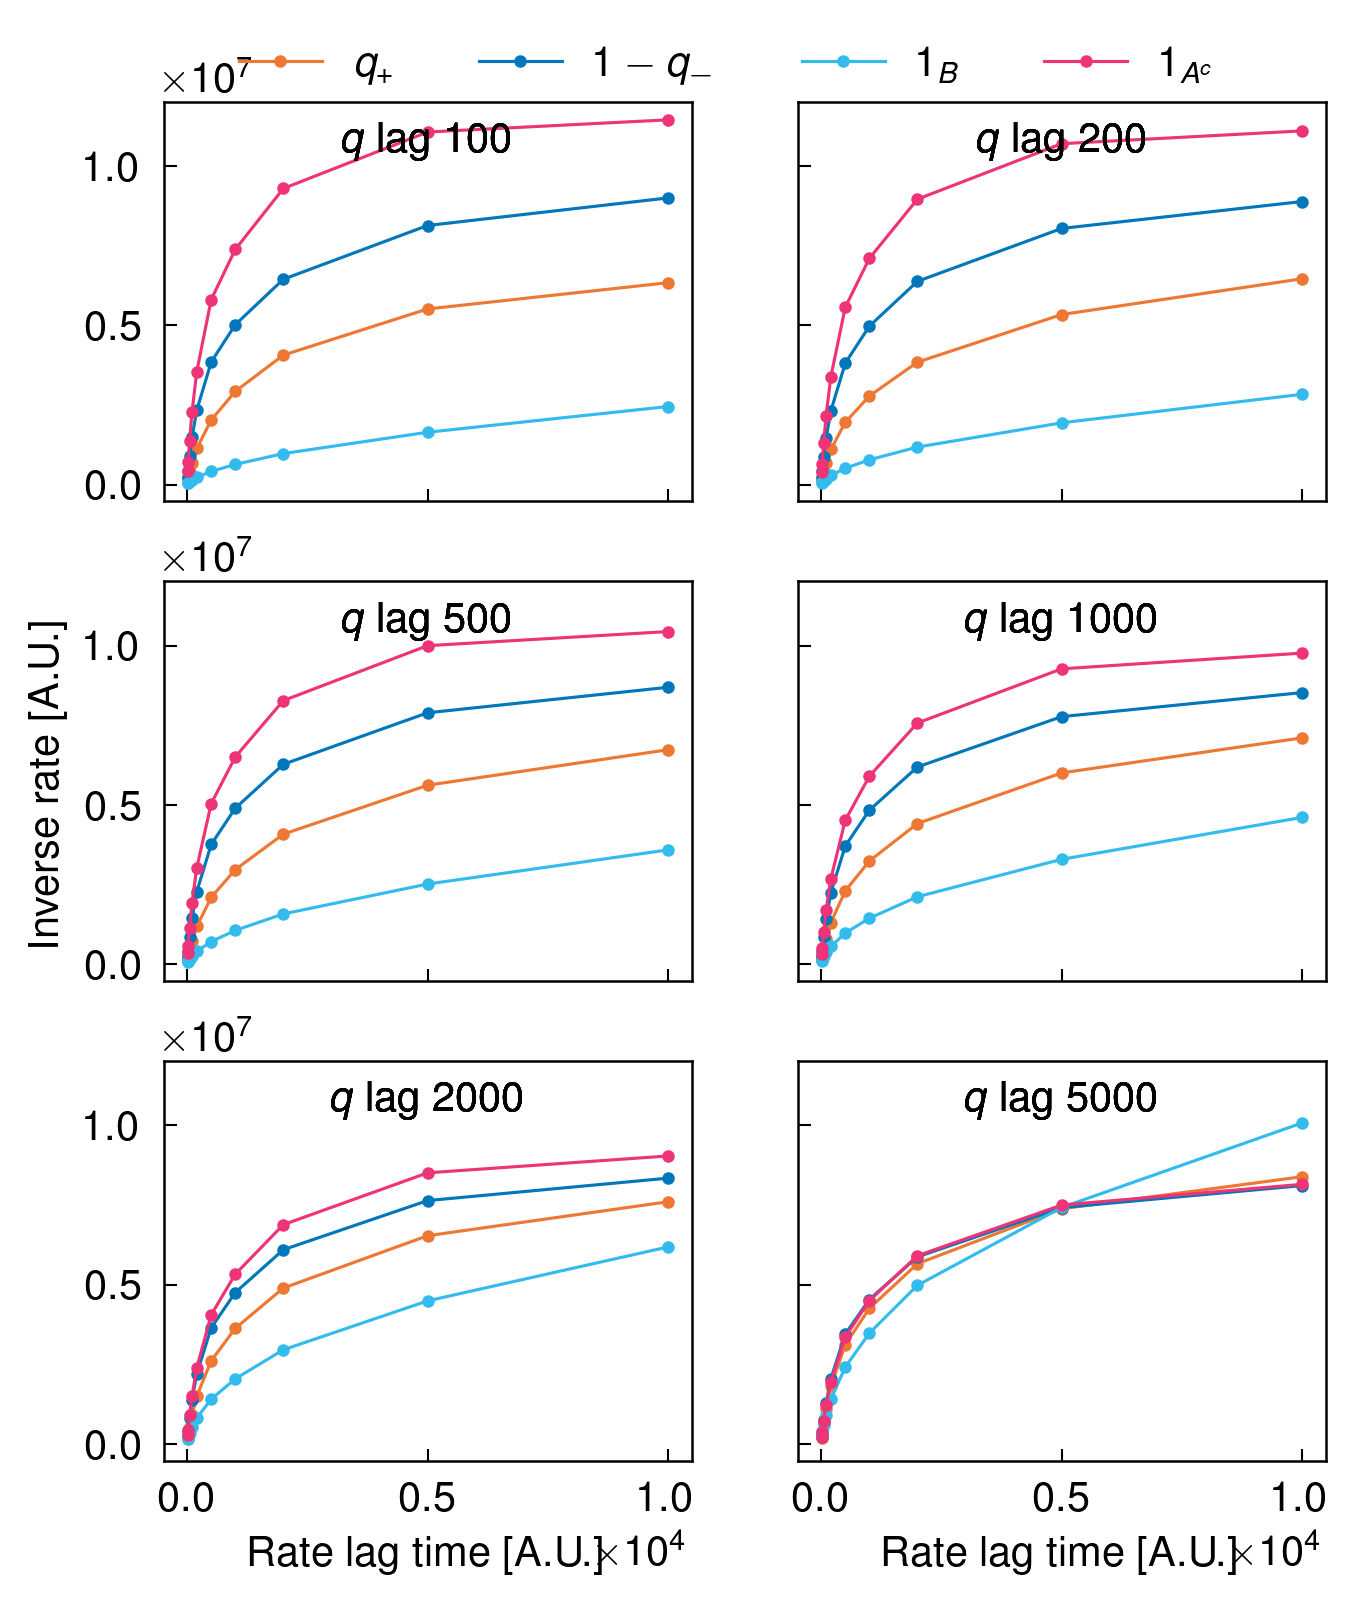

In [30]:
f, axs = plt.subplots(3, 2, figsize=(5, 6), dpi=300, sharex=True, sharey=True)
for i, ax in enumerate(axs.flat):
    for r in rates_lags[i]:
        ax.plot(rate_lags, 1 / r, "o-")
        pplt.text(0.5, 0.9, f"$q$ lag {lags[i]}", transform=ax.transAxes)
    ax.set_xlabel("Rate lag time [A.U.]")
    ax.label_outer()
axs[1, 0].set_ylabel("Inverse rate [A.U.]")
f.legend(
    ["$q_+$", "$1 - q_-$", r"$\mathbf{1}_B$", r"$\mathbf{1}_{A^c}$"],
    loc="center",
    ncol=4,
    bbox_to_anchor=[0.5, 0.9],
)
plt.tight_layout()

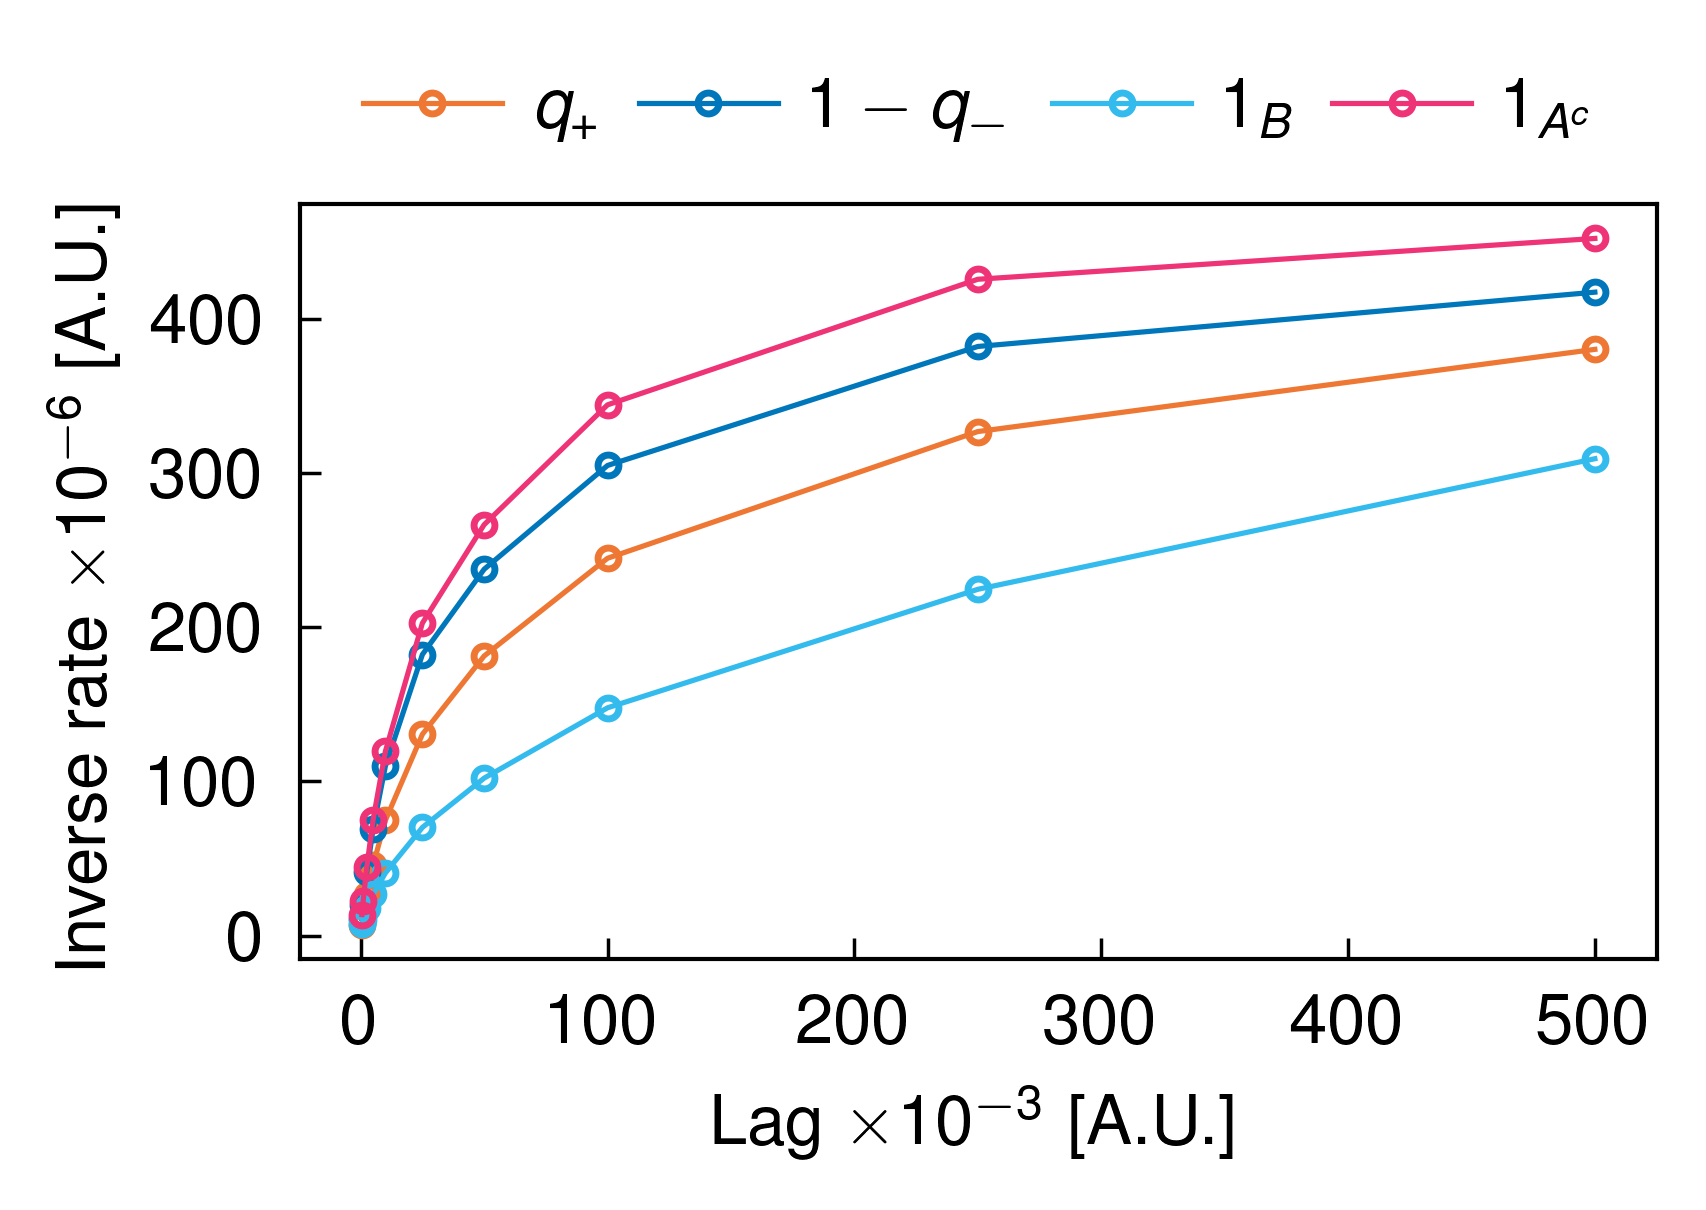

In [31]:
f = plt.figure(figsize=(3.5, 2), dpi=500)
ax = plt.gca()
# best looks like q of 5000 frames
labels = [
    r'$q_+$', 
    r'$1 - q_-$',
    r'$\mathbf{1}_B$',
    r'$\mathbf{1}_{A^c}$']

for r, label in zip(rates_lags[4], labels):
    # time steps in 0.1 ns
    ax.plot(rate_lags * 50 * 1e-3, 1 / r * 50 * 1e-6, 'o-', mfc='none', ms=3, label=label)
    
ax.set_xlabel(r"Lag $\times 10^{-3}$ [A.U.]")
ax.set_ylabel(r"Inverse rate $\times 10^{-6}$ [A.U.]")
pplt.legend(outside='top', ncol=4, ax=ax, handletextpad=0.5)

## gs $\rightarrow$ fs

In [32]:
rates_lags_gs2fs = np.load(f"{base_dir}/dga_data/rates_gs2fs.npy")

/scratch/local/jobs/7233195/ipykernel_3568426/2127959642.py:15: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


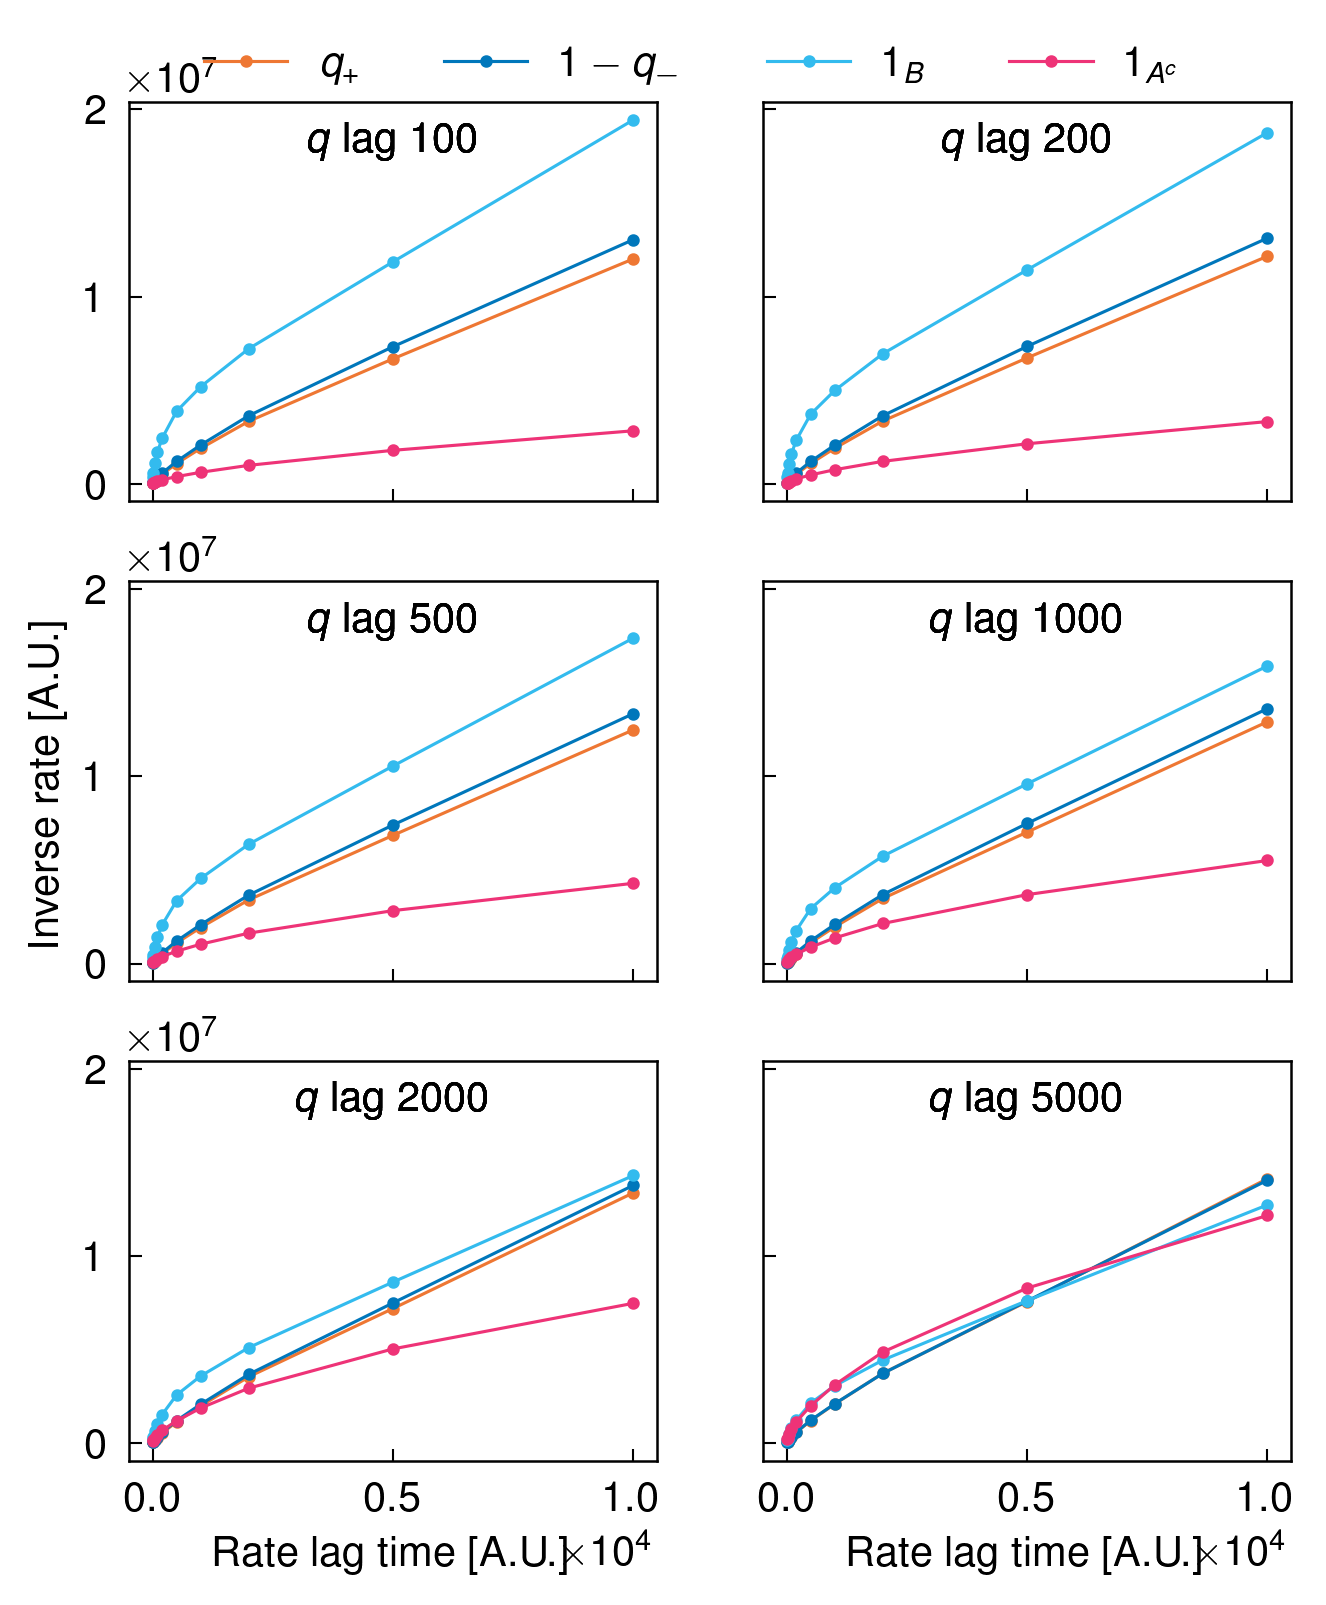

In [33]:
f, axs = plt.subplots(3, 2, figsize=(5, 6), dpi=300, sharex=True, sharey=True)
for i, ax in enumerate(axs.flat):
    for r in rates_lags_gs2fs[i]:
        ax.plot(rate_lags, 1 / r, "o-")
        pplt.text(0.5, 0.9, f"$q$ lag {lags[i]}", transform=ax.transAxes)
    ax.set_xlabel("Rate lag time [A.U.]")
    ax.label_outer()
axs[1, 0].set_ylabel("Inverse rate [A.U.]")
f.legend(
    ["$q_+$", "$1 - q_-$", r"$\mathbf{1}_B$", r"$\mathbf{1}_{A^c}$"],
    loc="center",
    ncol=4,
    bbox_to_anchor=[0.5, 0.9],
)
plt.tight_layout()

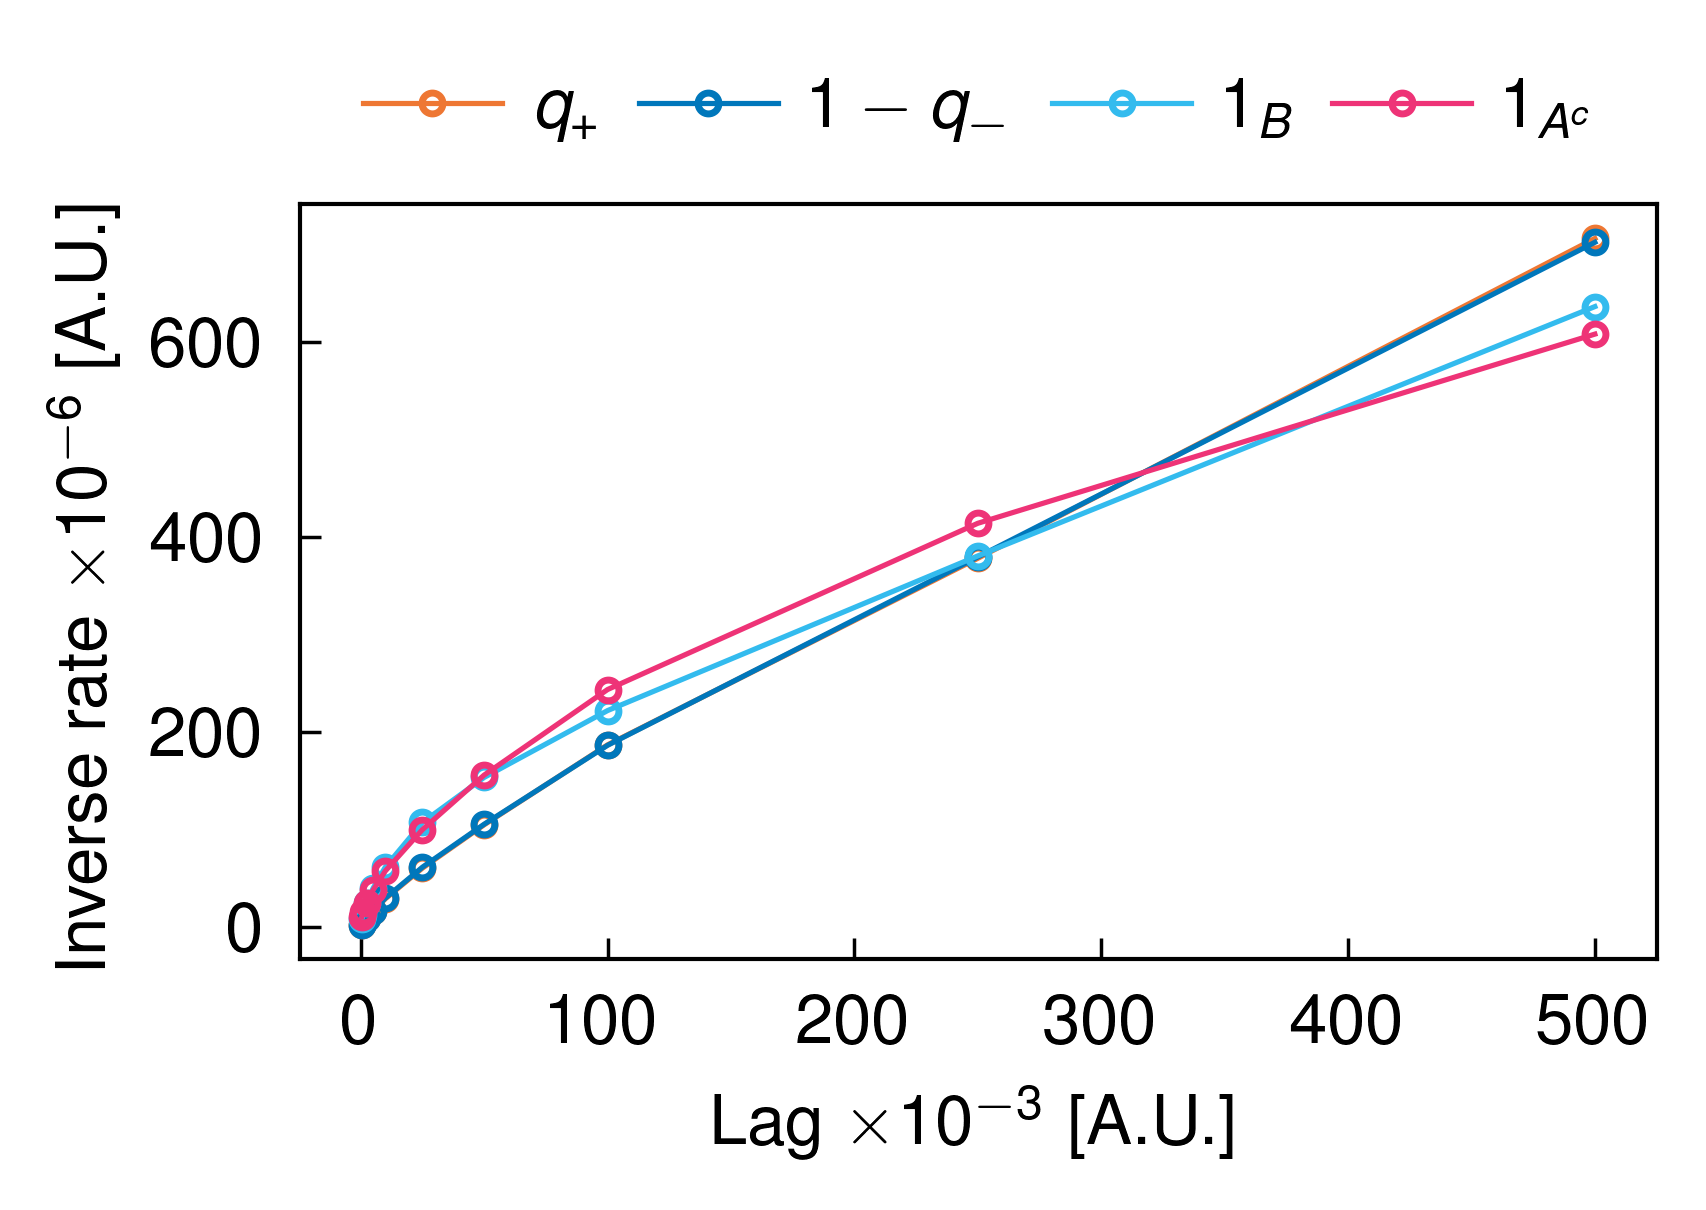

In [34]:
f = plt.figure(figsize=(3.5, 2), dpi=500)
ax = plt.gca()
# best looks like q of 5000 frames
labels = [
    r'$q_+$', 
    r'$1 - q_-$',
    r'$\mathbf{1}_B$',
    r'$\mathbf{1}_{A^c}$']

for r, label in zip(rates_lags_gs2fs[5], labels):
    # time steps in 0.1 ns
    ax.plot(rate_lags * 50 * 1e-3, 1 / r * 50 * 1e-6, 'o-', mfc='none', ms=3, label=label)
    
ax.set_xlabel(r"Lag $\times 10^{-3}$ [A.U.]")
ax.set_ylabel(r"Inverse rate $\times 10^{-6}$ [A.U.]")
pplt.legend(outside='top', ncol=4, ax=ax, handletextpad=0.5)